# ABOUT THIS NOTEBOOK
## Purpose
This notebook analyzes and explores the data set for the project.    
Some visualizations are generated to better understand the data.   

## Input
'data_set.pickle' generated by 'data_processing.ipynb'.

## Output
Analysis & visualizations of the data set.       

## Tasks Performed
* Load library packages
* Load pickle file
* Generate statistics
    * Correlation calculations using Pearson coefficient (linear relationships)
    * Feature importances using Random Forest Regressor (non-linear relationships)
* Generate visualizations
    * Correlation plot - Gap vs Input Features    
      Data for district 39
    * Demand, Supply & Gap vs Time
    * Weather, Temperature & Pollution vs time     
      Data is for entire city
    * Traffic vs Time     
      Data is for representative districts
    * Gap vs Time     
      Data is for representative districts

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.spatial.distance import cdist
from six.moves import cPickle as pickle

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn, scipy & six'

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')
print 'Matplotlib is inline. Seaborn defaults to whitegrid'

Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn, scipy & six
Matplotlib is inline. Seaborn defaults to whitegrid


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

# Read from Pickle
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save  # To help gc free up memory
    print 'Loaded pdata_set', pdata_set.shape
    
f.close()

Loaded pdata_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# GENERATE STATISTICS

## Correlation Matrices - Gap Prediction
Due to the large number of features, we will generate correlation matrices for subset of features at a time.    
This method only detects linear correlation.    
We will attempt correlation only with non-categorical features with this approach.

### Correlation with demand, supply

In [30]:
corr_set = pdata_set[['gap',
                      'demand_t-1', 'demand_t-2', 'demand_t-3',
                      'supply_t-1', 'supply_t-2', 'supply_t-3']]
corr_set.corr()

,gap,demand_t-1,demand_t-2,demand_t-3,supply_t-1,supply_t-2,supply_t-3
gap,1.000000,0.734876,0.696001,0.652917,0.449564,0.448819,0.445625
demand_t-1,0.734876,1.000000,0.982108,0.960845,0.920754,0.912336,0.905883
demand_t-2,0.696001,0.982108,1.000000,0.982115,0.911862,0.920770,0.912358
demand_t-3,0.652917,0.960845,0.982115,1.000000,0.905926,0.911882,0.920785
supply_t-1,0.449564,0.920754,0.911862,0.905926,1.000000,0.987273,0.978827
supply_t-2,0.448819,0.912336,0.920770,0.911882,0.987273,1.000000,0.987282
supply_t-3,0.445625,0.905883,0.912358,0.920785,0.978827,0.987282,1.000000


#### Observation    
Correlation with demand is 65+%, supply is 45+%. These features exhibit a significant linear relationship with gap prediction.

### Correlation with POI

In [6]:
corr_set = pdata_set[['gap',
                      'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4'
                     ]]
corr_set.corr()

,gap,poi_pc1,poi_pc2,poi_pc3,poi_pc4
gap,1.000000,-3.629206e-01,3.371992e-02,2.380267e-03,3.332948e-04
poi_pc1,-0.362921,1.000000e+00,2.169243e-13,-4.346786e-13,-3.879830e-15
poi_pc2,0.033720,2.169243e-13,1.000000e+00,1.896455e-14,-1.129314e-13
poi_pc3,0.002380,-4.346786e-13,1.896455e-14,1.000000e+00,-3.028175e-14
poi_pc4,0.000333,-3.879830e-15,-1.129314e-13,-3.028175e-14,1.000000e+00


#### Observation     
Correlation with POI PC1 is -36%, other PCs have correlation of 3% or less. POI PC1 exhibits a significant linear relationship with gap prediction. However, the remaining PCs do not exhibit a linear relationship with gap prediction. We will determine if a non-linear relationship between gap prediction and these other POI PCs (pc2, pc3, pc4) exists in the next section.

### Correlation with traffic levels

In [7]:
corr_set = pdata_set[['gap',
                      'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4'
                     ]]
corr_set.corr()

,gap,tj_lvl1,tj_lvl2,tj_lvl3,tj_lvl4
gap,1.000000,0.332082,0.400163,0.426815,0.391343
tj_lvl1,0.332082,1.000000,0.874907,0.844930,0.890968
tj_lvl2,0.400163,0.874907,1.000000,0.976018,0.954505
tj_lvl3,0.426815,0.844930,0.976018,1.000000,0.959998
tj_lvl4,0.391343,0.890968,0.954505,0.959998,1.000000


#### Observation     
Correlation with traffic is 33+% for all levels. All these features exhibit a significant linear relationship with gap prediction.

### Correlation with temperature & pollution

In [22]:
corr_set = pdata_set[['gap',
                      'temperature', 'pollution'
                     ]]
corr_set.corr()

,gap,temperature,pollution
gap,1.000000,-0.022997,-0.001849
temperature,-0.022997,1.000000,0.292840
pollution,-0.001849,0.292840,1.000000


#### Observation    
Correlation of temperature & pollution is ~2% or below. These features do not have a linear relationship with gap prediction. We will determine if a non-linear relationship between gap prediction and these variables exists in the next section.

### Correlation with day, time slot

In [23]:
corr_set = pdata_set[['gap',
                      'num_day', 'time_slot'
                     ]]
corr_set.corr()

,gap,num_day,time_slot
gap,1.000000,0.021415,0.020335
num_day,0.021415,1.000000,0.000000
time_slot,0.020335,0.000000,1.000000


#### Observation     
Correlation of day, time slot is ~2%. These features do not have a linear relationship with gap prediction. We will determine if a non-linear relationship between gap prediction and these variables exists in the next section.

## Feature Importance - Random Forest Regressor
Since correlation matrix only computes linear dependencies, we will use tree based methods to identify non-linear relationships.    
We will exclude features that we have already identified to be useful using the Pearson coefficient method.
We will now include categorical variables for this analysis.

### Importance between district id, weather, temperature, pollution, POI (2,3,4), day, time slot

Use MSE as the score function - Only supported metric for Random Forest Regressor.
 1) pollution                      0.203875
 2) temperature                    0.142247
 3) poi_pc2                        0.091344
 4) ts_3                           0.071928
 5) ts_4                           0.058811
 6) poi_pc3                        0.050224
 7) ts_2                           0.046292
 8) ts_6                           0.043902
 9) ts_5                           0.038283
10) ts_1                           0.029546
11) weekday_2                      0.023124
12) numday_4                       0.018655
13) ts_0                           0.017428
14) poi_pc4                        0.016301
15) numday_0                       0.016095
16) numday_3                       0.015174
17) weekday_1                      0.014792
18) wthr_0                         0.014707
19) numday_1                       0.014208
20) ts_7                           0.012175
21) weekday_0                      0.

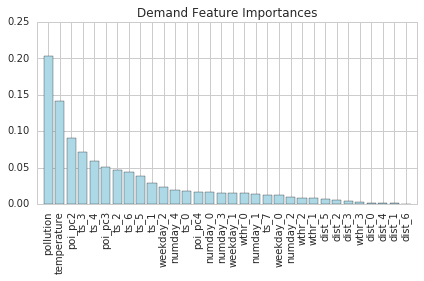

In [28]:
predictors = ['dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
              'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3', 
              'temperature', 'pollution',
              'poi_pc2', 'poi_pc3', 'poi_pc4',
              'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 
              'weekday_0', 'weekday_1', 'weekday_2',
              'ts_0','ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7'] 

# Scoring Metric - MSE
print ("Use MSE as the score function - Only supported metric for Random Forest Regressor.")

# Input Samples and Target Values
X = pdata_set[predictors]
y = pdata_set['gap']

# Fit Random Forest Regressor
# Large n_estimators, small max_depth to avoid overfitting
alg = RandomForestRegressor(n_jobs=-1, random_state=1, n_estimators=1000, max_depth=20)
rfr = alg.fit(X, y)


# Feature importances
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = predictors
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Demand Feature Importances')
plt.bar(range(X.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

#### Observation     
Time slot (combine all bits), temperature, pollution rank as the top features. We will rerun the random forest regressor by dropping these features.

### Rerun after dropping time slot, temperature, pollution

Use MSE as the score function - Only supported metric for Random Forest Regressor.
 1) poi_pc2                        0.248679
 2) poi_pc3                        0.139775
 3) wthr_1                         0.115490
 4) wthr_0                         0.089828
 5) numday_1                       0.055910
 6) numday_4                       0.049422
 7) numday_0                       0.042783
 8) weekday_0                      0.040246
 9) weekday_2                      0.036531
10) poi_pc4                        0.035711
11) weekday_1                      0.033752
12) wthr_3                         0.029499
13) wthr_2                         0.023771
14) numday_2                       0.021563
15) numday_3                       0.016092
16) dist_2                         0.006755
17) dist_5                         0.005601
18) dist_4                         0.002713
19) dist_0                         0.002258
20) dist_3                         0.002122
21) dist_1                         0.

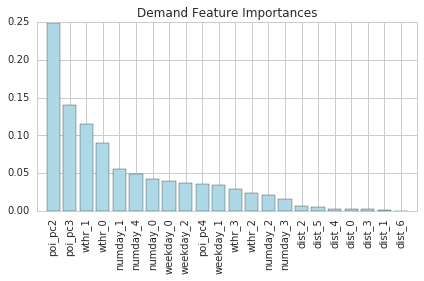

In [29]:
predictors = ['dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
              'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3', 
              'poi_pc2', 'poi_pc3', 'poi_pc4',
              'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 
              'weekday_0', 'weekday_1', 'weekday_2'] 

# Scoring Metric - MSE
print ("Use MSE as the score function - Only supported metric for Random Forest Regressor.")

# Input Samples and Target Values
X = pdata_set[predictors]
y = pdata_set['gap']

# Fit Random Forest Regressor
# Large n_estimators, small max_depth to avoid overfitting
alg = RandomForestRegressor(n_jobs=-1, random_state=1, n_estimators=1000, max_depth=20)
rfr = alg.fit(X, y)


# Feature importances
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = predictors
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Demand Feature Importances')
plt.bar(range(X.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

#### Observation     
Weather (combine all bits), POI (pc2) rank as the top features. The remaining features are of lower importance.

# GENERATE VISUALIZATIONS

## Functions

In [7]:
def time_axisdf(df):
    '''Combine num_day and time_slot to create a new time_axis.
    Each day after the first day accumulates 144 time slots. 
    Returned value includes the sum of the times slots from num_day and the time_slot argument.
    
    Arguments:
    data frame with 'num_day' (ranging from 1 to 21), 'time_slot' (ranging from 1 to 144)
    
    Returns:
    time_axis value
    '''
    return (int(((df['num_day'] - 1)*144) + df['time_slot']))

## Correlation Plot - Gap vs Input Features
### Data for district 39 (centroid for POI cluster 0)

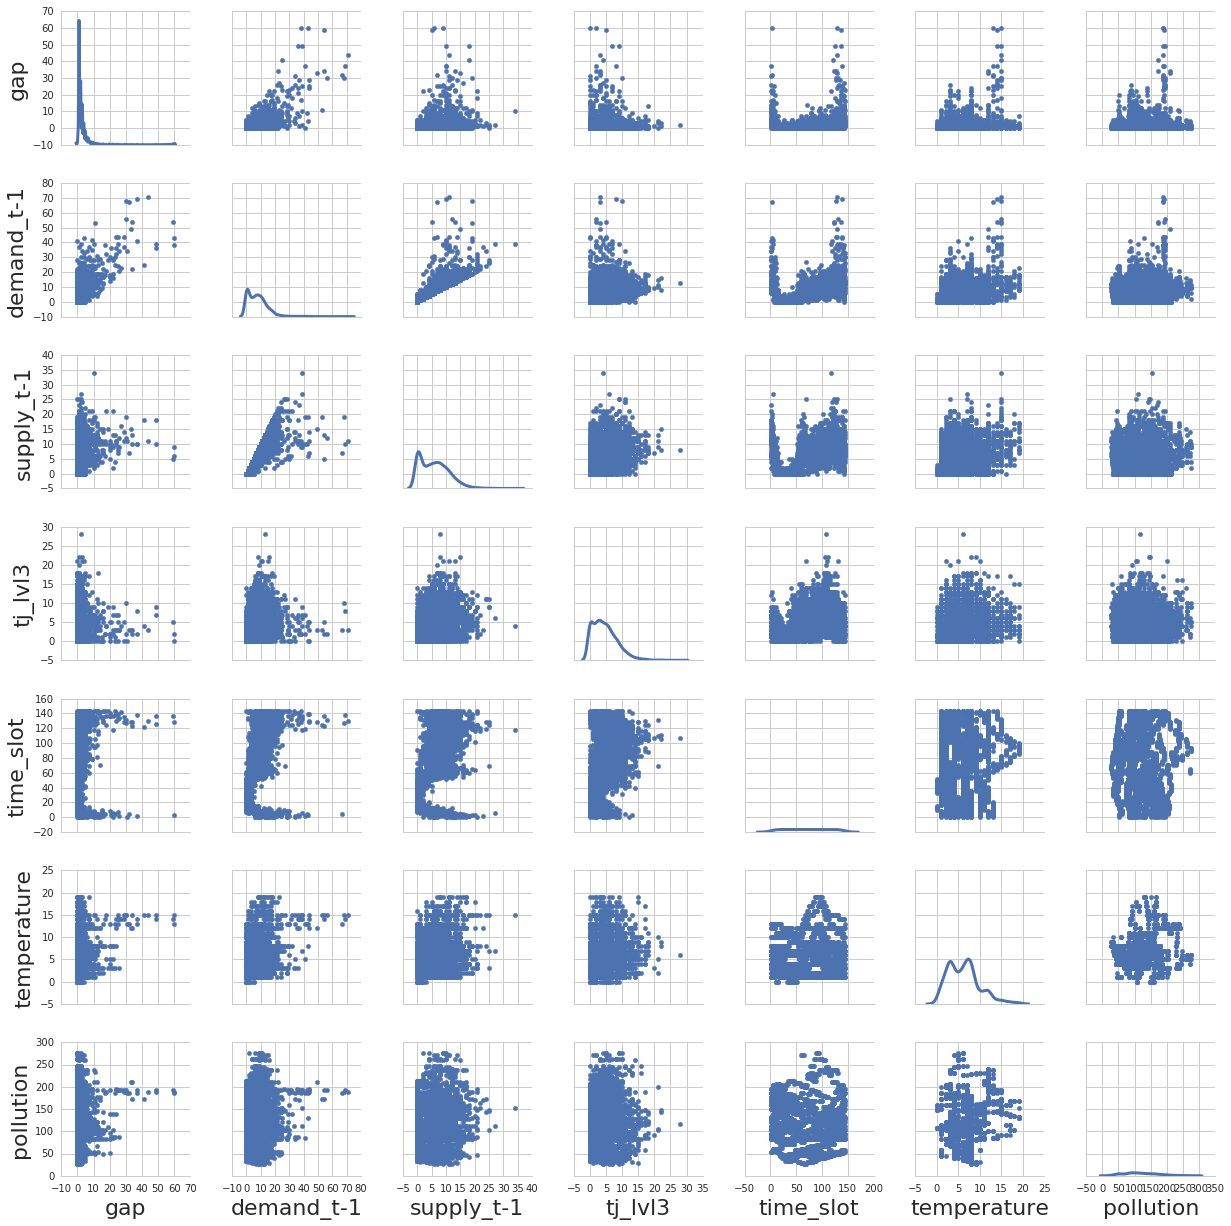

In [27]:
plot_set = pdata_set[(pdata_set['district_id'].isin([39]))]
corrplot = plot_set[['gap', 'demand_t-1', 'supply_t-1', 'tj_lvl3', 'time_slot', 'temperature', 'pollution']]
g = sns.PairGrid(corrplot)
g = g.map_upper(plt.scatter)
g = g.map_lower(plt.scatter)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)

#### Observation (from first row)
* Gap values are distributed primarily between 0 and 10 with a long tail that extends to ~60
* Positive correlation with demand_t-1, supply_t-1 are seen.    
  When demand_t-1 rises above 30, gap value gets sparser and displays a clearer positive correlation.     
  This indicates that sudden spikes in demand lead to gaps.
* Inverse correlation is observed with traffic level.     
  This indicates that heavy traffic hours probably has a more abundant supply of cabs.
* Gap value shows a linear increase as the day progresses.    
  However, gap spikes are observed from late evening hours to early morning. This is probably due to a shorter supply of cabs during these times.
* Gap correlation with temperature & pollution are less clear.    
  There are some ranges of temperature & pollution values that exhibit a wide range of gap values.    
  My conclusion is that these ranges of temperature & pollution are more common during the 21 day period for which we have data.

## Demand, Supply & Gap vs Time (21 days)
### Data for district 39 which is the centroid for POI cluster 0

In [21]:
plt.rcParams.update({'font.size': 22, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f465bbdd710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f465ba07e50>], dtype=object)

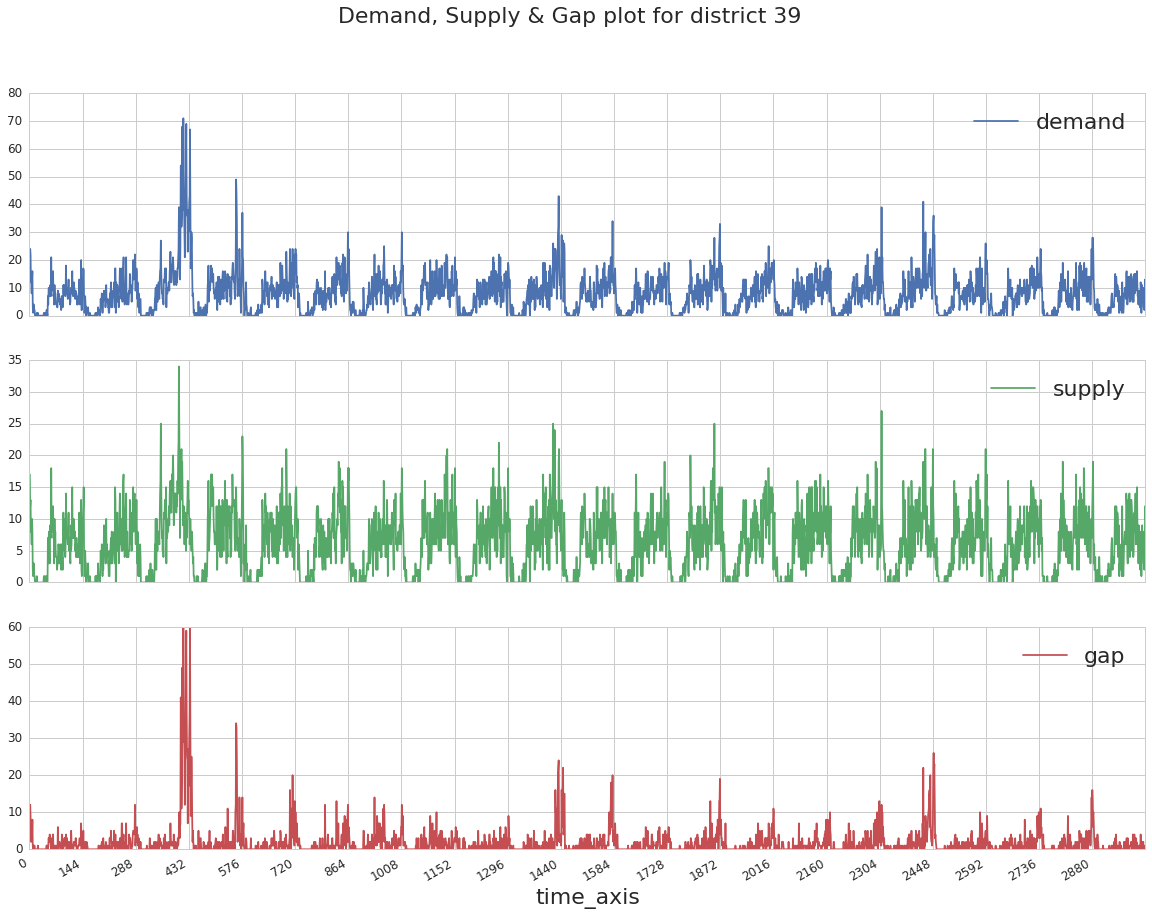

In [35]:
# Disable warning about chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

gap_plot = pd.DataFrame()
gap_plot = pdata_set[(pdata_set['district_id'].isin([39]))]
gap_plot['time_axis'] = gap_plot.apply(time_axisdf, axis=1)
gap_plot = gap_plot[['time_axis', 'demand', 'supply', 'gap']]
gap_plot.drop_duplicates(inplace=True)
gap_plot.set_index('time_axis', inplace=True)

gap_plot.plot(subplots=True, sharex=True, figsize=(20,15), 
              title='Demand, Supply & Gap plot for district 39', fontsize=12,
              xticks = np.arange(0,21*144,144)
             )

#### Observation
* Demand and gap values tend to generally increase from morning to late evening.
* Spikes in demand indicate commute hours during week days.

## Weather, Temperature & Pollution vs Time (21 days)
### Data is for entire city

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4660c33ad0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f465be0e3d0>], dtype=object)

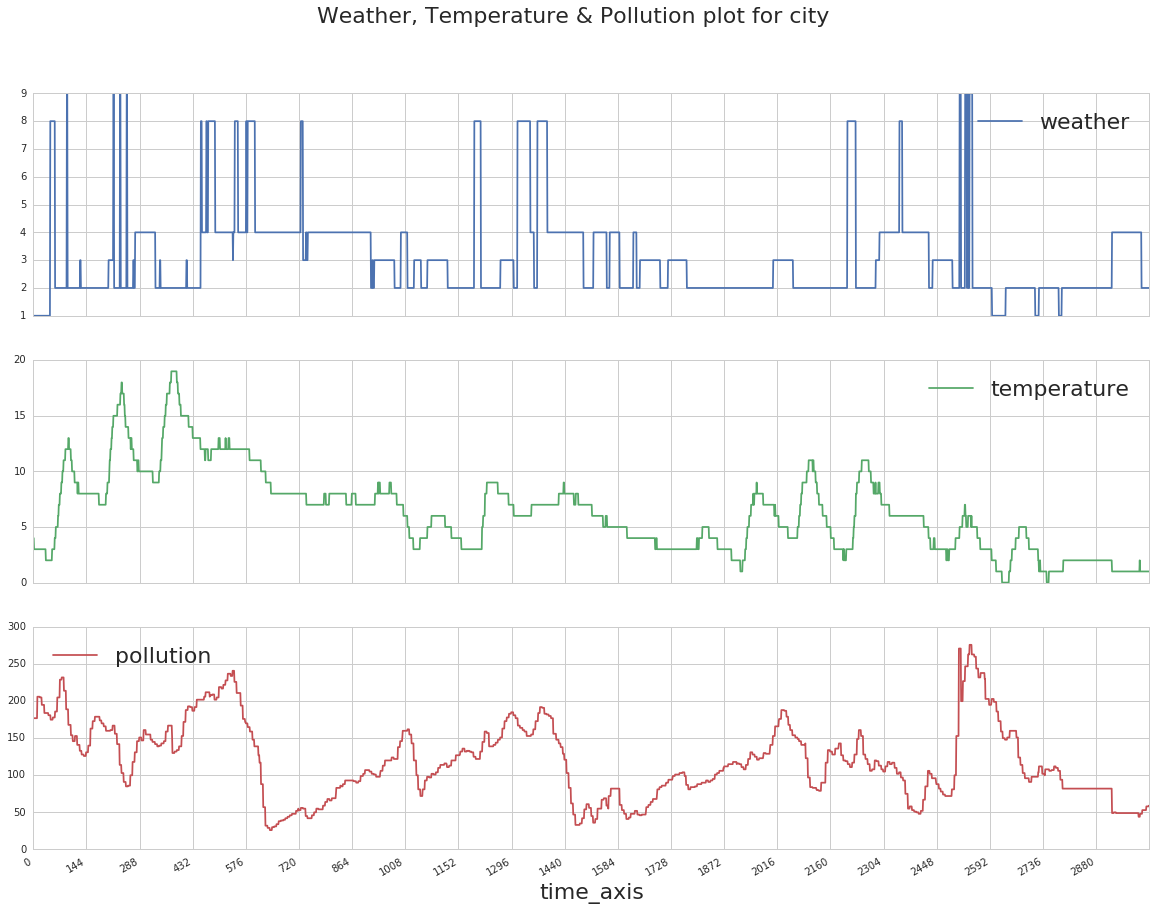

In [34]:
# Disable warning about chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

weather_plot = pdata_set[(pdata_set['district_id'].isin([39]))]
weather_plot['time_axis'] = weather_plot.apply(time_axisdf, axis=1)
weather_plot = weather_plot[['time_axis', 'weather', 'temperature', 'pollution']]
weather_plot.drop_duplicates(inplace=True)
weather_plot.set_index('time_axis', inplace=True)

weather_plot.plot(subplots=True, sharex=True, figsize=(20,15), 
                  title='Weather, Temperature & Pollution plot for city',
                  xticks = np.arange(0,21*144,144)
                 )

## Traffic vs Time (21 days)
### Data is for representative districts
We will plot tj_lvl3 for all representative districts over 21 days.

In [5]:
# List of representative districts derived from POI analysis
rep_dists = [12,19,23,39,46,51]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f46606fd6d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f4660464350>], dtype=object)

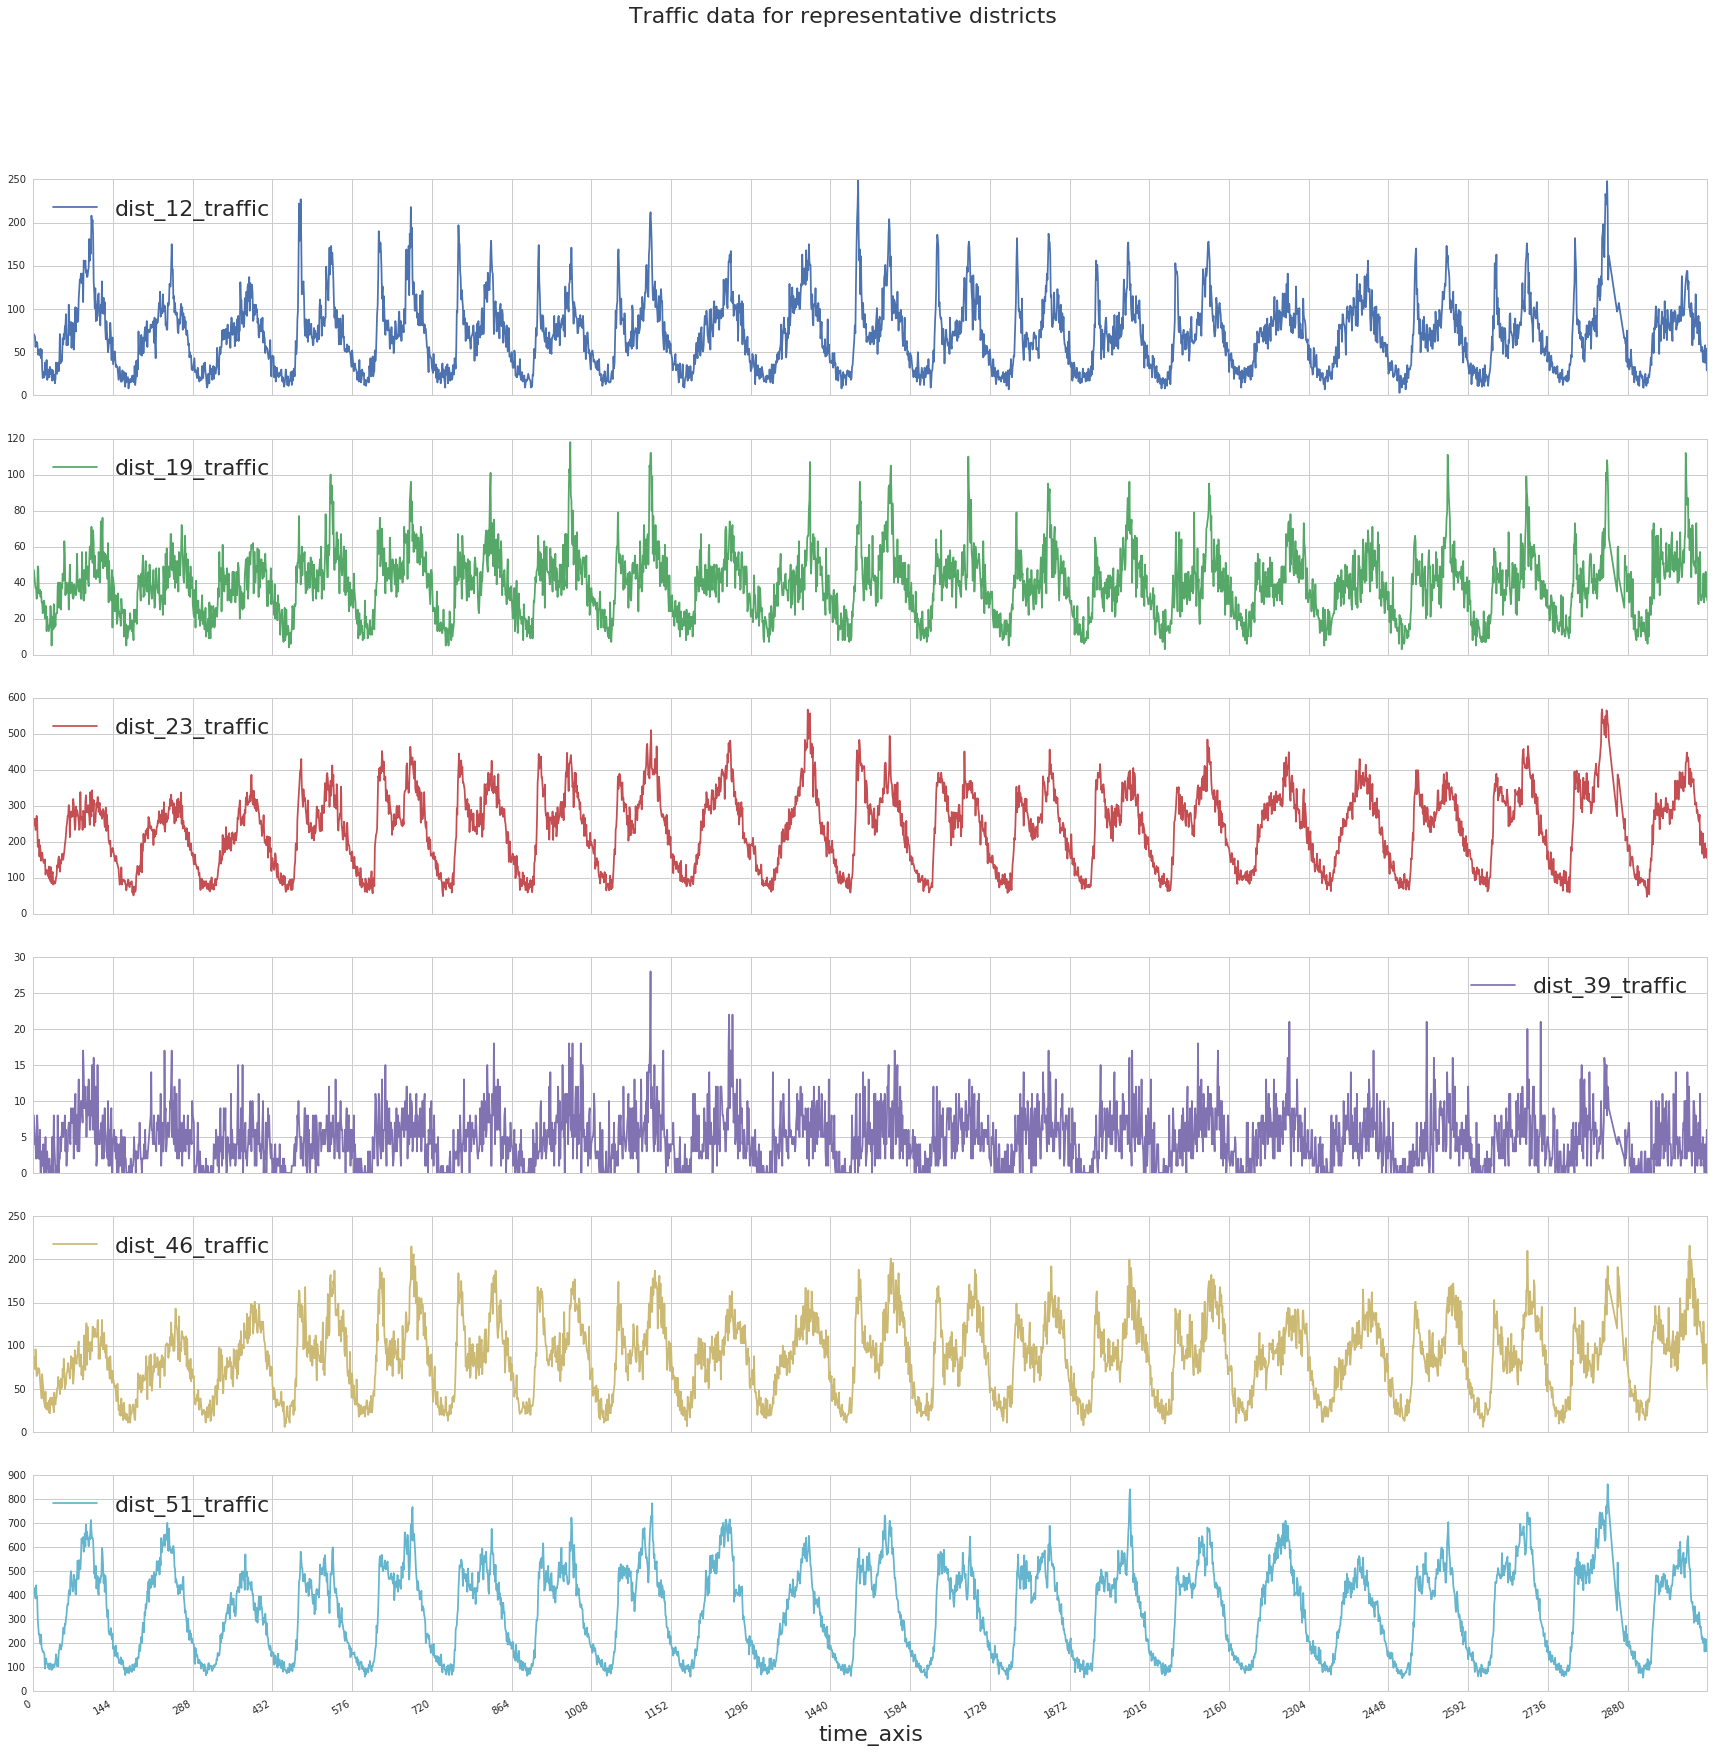

In [33]:
traffic_plot = pdata_set[(pdata_set['district_id'].isin(rep_dists))]
traffic_plot['time_axis'] = traffic_plot.apply(time_axisdf, axis=1)
traffic_plot = traffic_plot[['time_axis', 'tj_lvl3', 'district_id']]
traffic_plot.set_index('time_axis', inplace=True)

# Create separate columns for each district
for dist in rep_dists:
    traffic_plot['dist_' + str(dist) + '_traffic'] = traffic_plot[(traffic_plot.district_id == dist)]['tj_lvl3']

traffic_plot.drop(['district_id', 'tj_lvl3'], axis=1, inplace=True)
traffic_plot.drop_duplicates(inplace=True)

traffic_plot.plot(subplots=True, grid=True, fontsize=10, figsize=(30,30), 
                  title='Traffic data for representative districts',
                  xticks = np.arange(0,21*144,144)
                 )

#### Observations
* The difference between the districts is clear by noticing the number of roads in each district.    
  District 39 has ~30 while district 51 has ~900.
* Districts with larger number of roads exhibit a clear and pronounced traffic pattern.
* The typical pattern indicates an increase in traffic from morning to evening. A drop-off is noticed in the late evening, early morning.
* Spikes in traffic are observed during commute hours during week days.
* Holiday/weekend traffic does not exhibit this commute hour pattern.

## Gap vs Time (21 days)
### Data is for representative districts
We will plot gap for all representative districts over 21 days.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f465bb230d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f465b57b290>], dtype=object)

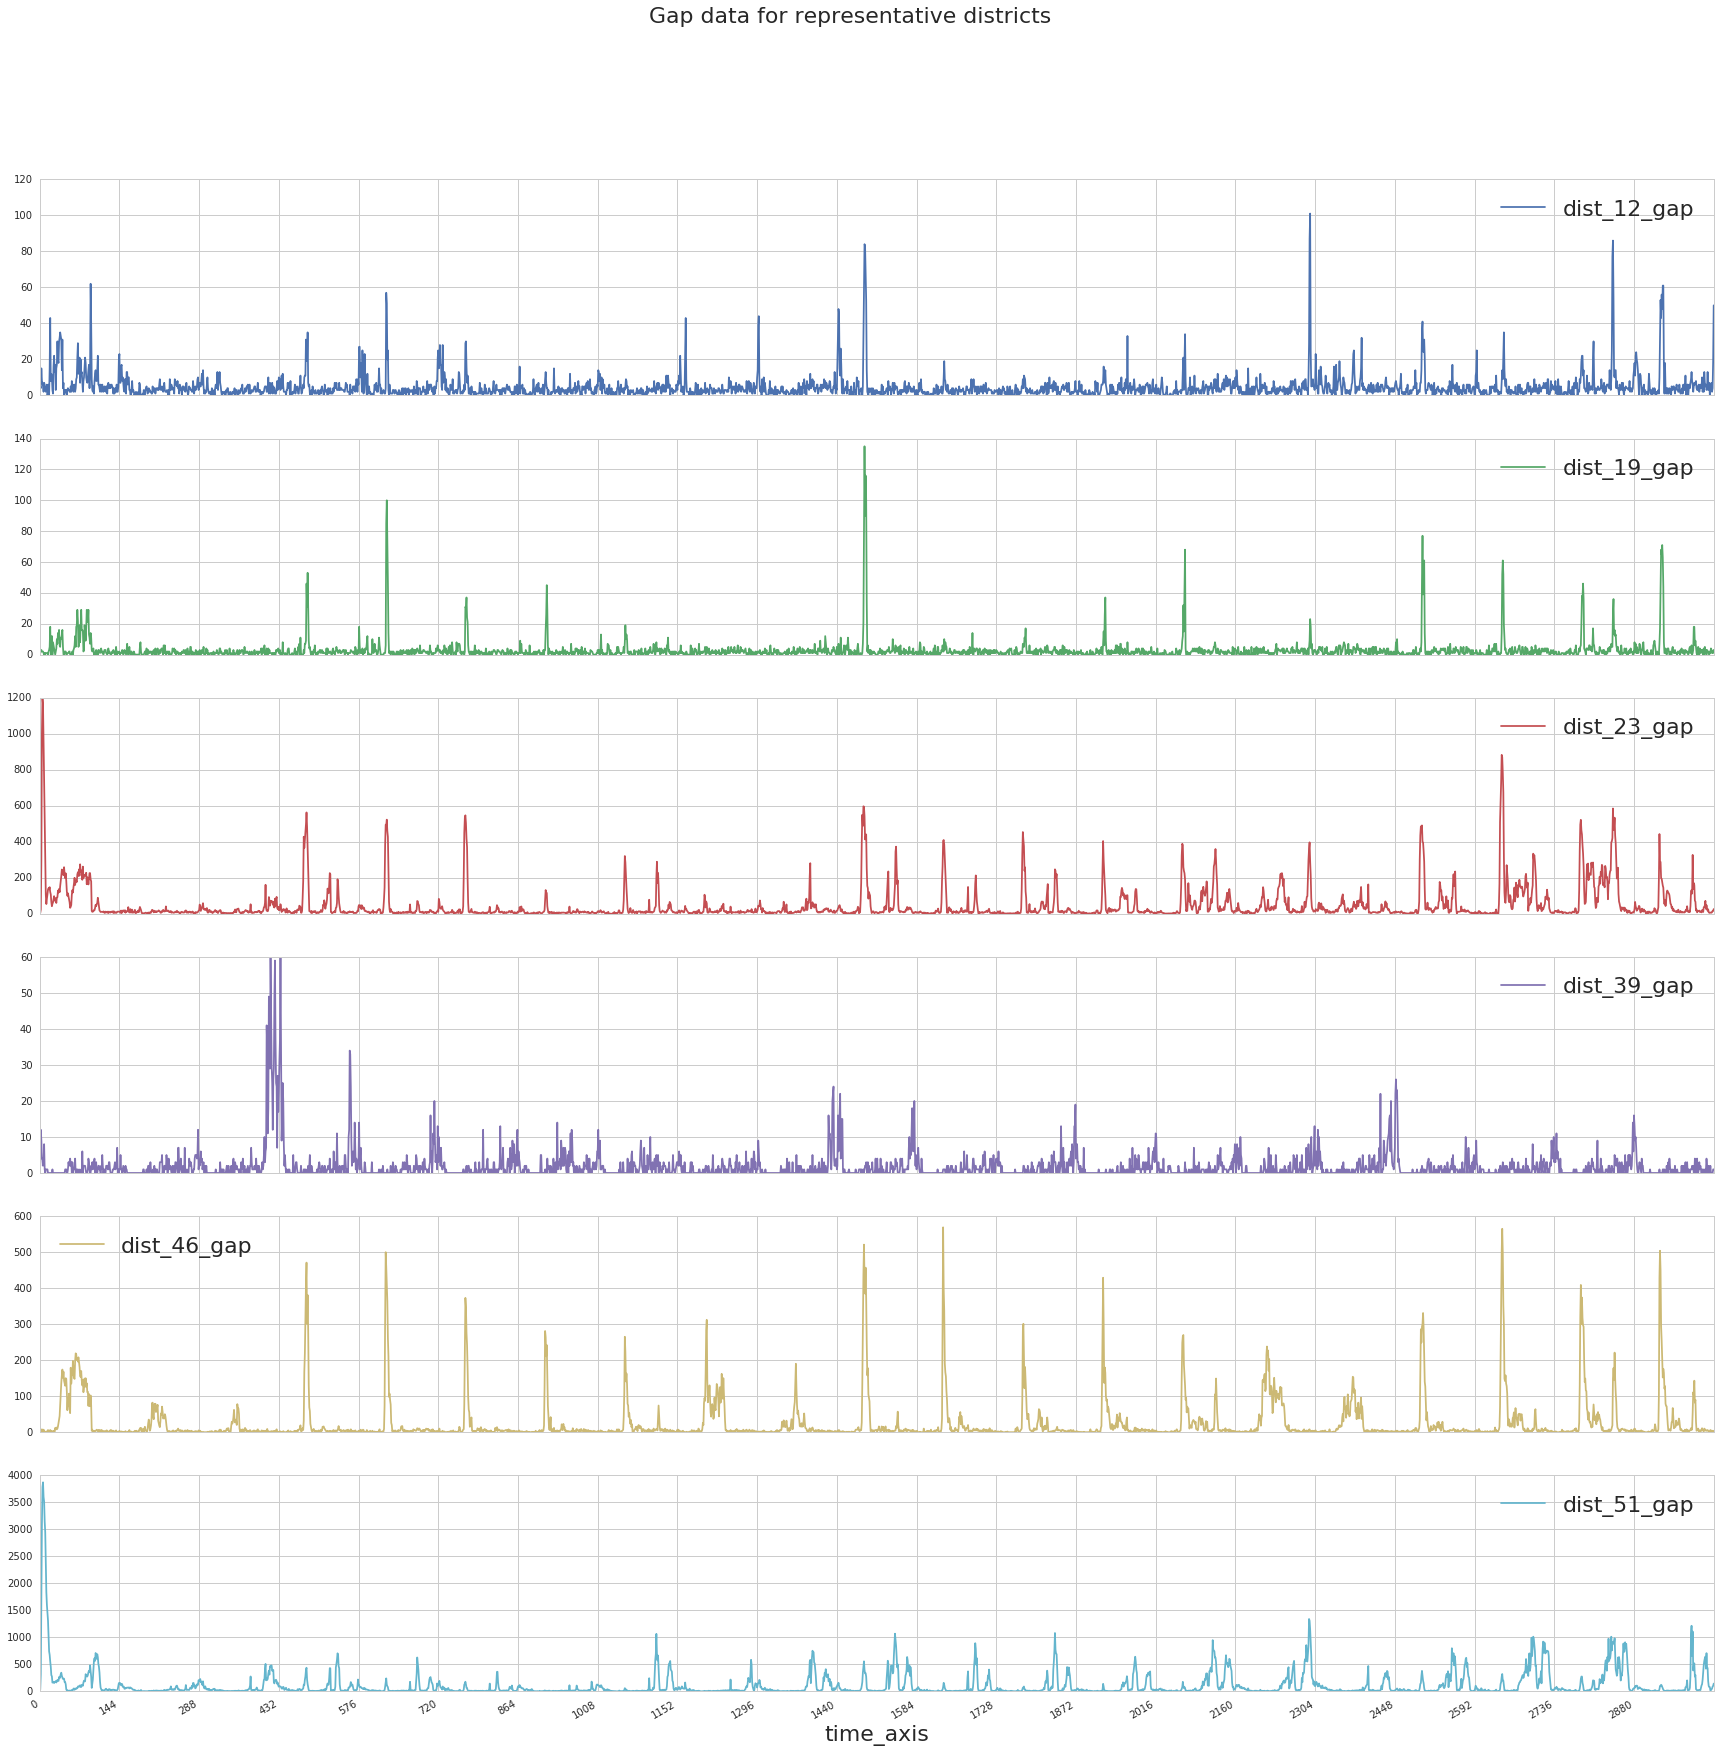

In [36]:
# Disable warning about chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

gap_plot = pdata_set[(pdata_set['district_id'].isin(rep_dists))]
gap_plot['time_axis'] = gap_plot.apply(time_axisdf, axis=1)
gap_plot = gap_plot[['time_axis', 'gap', 'district_id']]
gap_plot.set_index('time_axis', inplace=True)

# Create separate columns for each district
for dist in rep_dists:
    gap_plot['dist_' + str(dist) + '_gap'] = gap_plot[(gap_plot.district_id == dist)]['gap']

gap_plot.drop(['district_id', 'gap'], axis=1, inplace=True)
gap_plot.drop_duplicates(inplace=True)

gap_plot.plot(subplots=True, grid=True, fontsize=10, figsize=(30,30), 
              title='Gap data for representative districts',
              xticks = np.arange(0,21*144,144)
             )

#### Observations
* The difference between the districts is clear by noticing the gap values in each district.    
  District 39 has a max gap of ~60 while district 51 has ~4000.
* Spike in gaps in some districts seems to coincide with commute traffic pattern during week days.